## Nuclei segmentation

#### Preparations

Before you start executing code get GPU acces Runtime -> Change Runtime Type -> T4 GPU

The cell below installs and imports necessary libraries which make available the functions to open, visualize and segment images.

In [ ]:
!pip install cellpose
!pip install scikit-image

When you execute the cell below, a github repository will be cloned and test images will be available in your session. 

You can see available files by clicking the folder icon in the left side menu. 

Alternatively you can upload files directly from your drive to the session sotrage by using the upload button (in the Files tab).

In [20]:
!git clone https://github.com/fjorka/OMIBS2025.git

Cloning into 'OMIBS2025'...


Import nexessary packages:

In [3]:
import pandas as pd
import numpy as np
from tifffile import imread, imwrite
import matplotlib.pyplot as plt
from cellpose import models
from skimage.measure import regionprops_table



Welcome to CellposeSAM, cellpose v
cellpose version: 	4.0.6 
platform:       	win32 
python version: 	3.11.13 
torch version:  	2.7.1+cu126! The neural network component of
CPSAM is much larger than in previous versions and CPU excution is slow. 
We encourage users to use GPU/MPS if available. 




Confirm access to GPU:

In [4]:
import torch
torch.cuda.is_available()

True

#### Open and display test image

In [ ]:
# define pathway to the image
im_path = './OMIBS2025/sample_images/2187T-5_2.0.4_P0007_Z00_DAPI.tif' 

# load in image to a variable 'im'
im = imread(im_path)

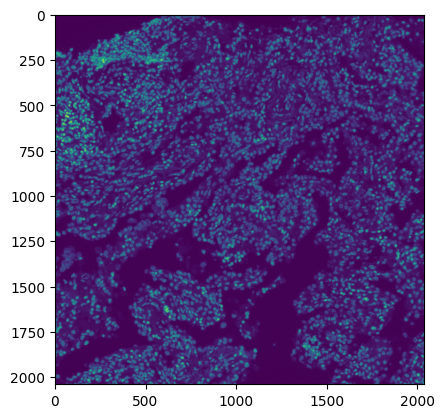

In [6]:
# display the test image
plt.imshow(im)

#### Segmentation

Let's create a small sample image:

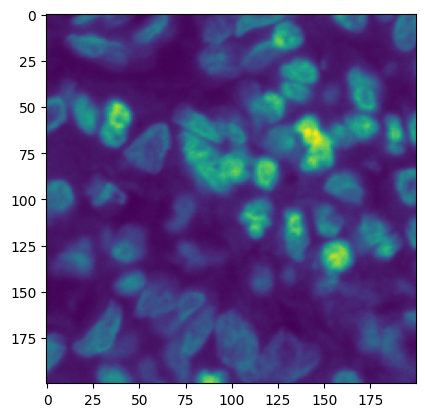

In [7]:
# cut the sample image
im_small = im[1000:1200,1000:1200]

# display the test image
plt.imshow(im_small)

Sam-Cellpose (https://cellpose.readthedocs.io/en/latest/settings.html) provides 'Flow Threshold', 'Cellprob Threshold' and 'niter' segmentation parameters. Explore their meaning in the documentation and change the values during the segmentation step to optimize the results.

In [10]:
# the model used for the first time in the session will be imported first
model = models.CellposeModel(gpu=True)

# perform segmentation and store the result in the 'mask' image
flow_threshold = 0.4
cellprob_threshold = 0.0
niter = 0
mask, *_ = model.eval(im_small, flow_threshold=flow_threshold, cellprob_threshold=cellprob_threshold, niter=niter)   

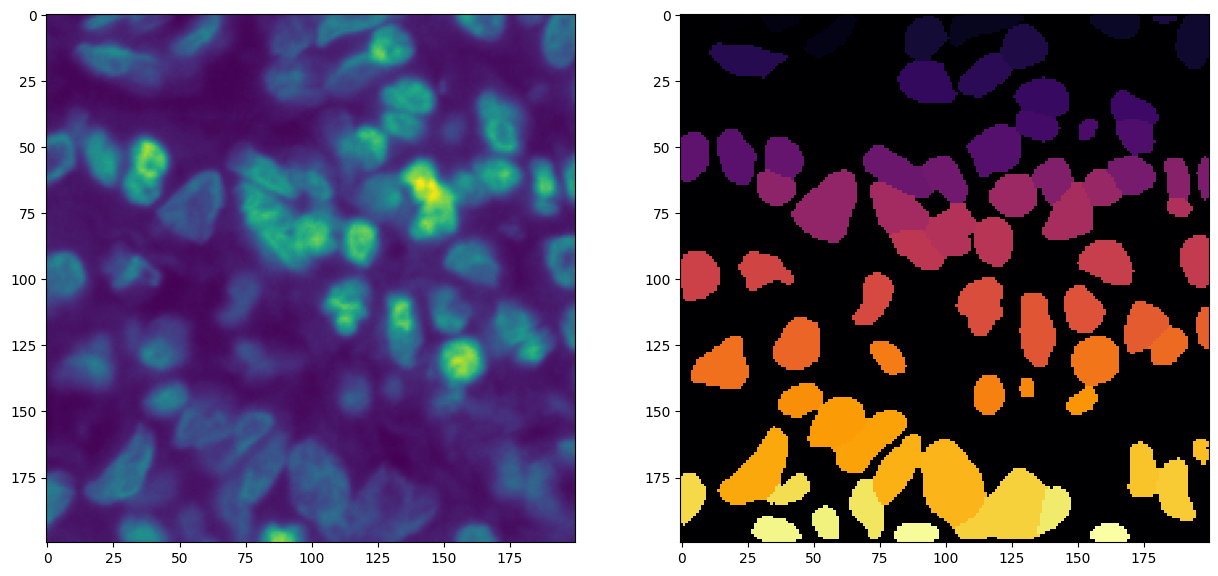

In [11]:
# visualize the results

fig,axes = plt.subplots(1,2,figsize=(15,10))

# display the original sample image
axes[0].imshow(im_small)

# display segmentation mask (each objects is displayed in different color)
axes[1].imshow(mask,cmap='inferno',interpolation='nearest')

Once you identified the best segmentation approach, let's segment the whole image (it should run around 3 min):

In [12]:
# perform segmentation and store the result in the 'mask' image
mask, *_ = model.eval(im,diameter = 25)

Resizing is depricated in v4.0.1+


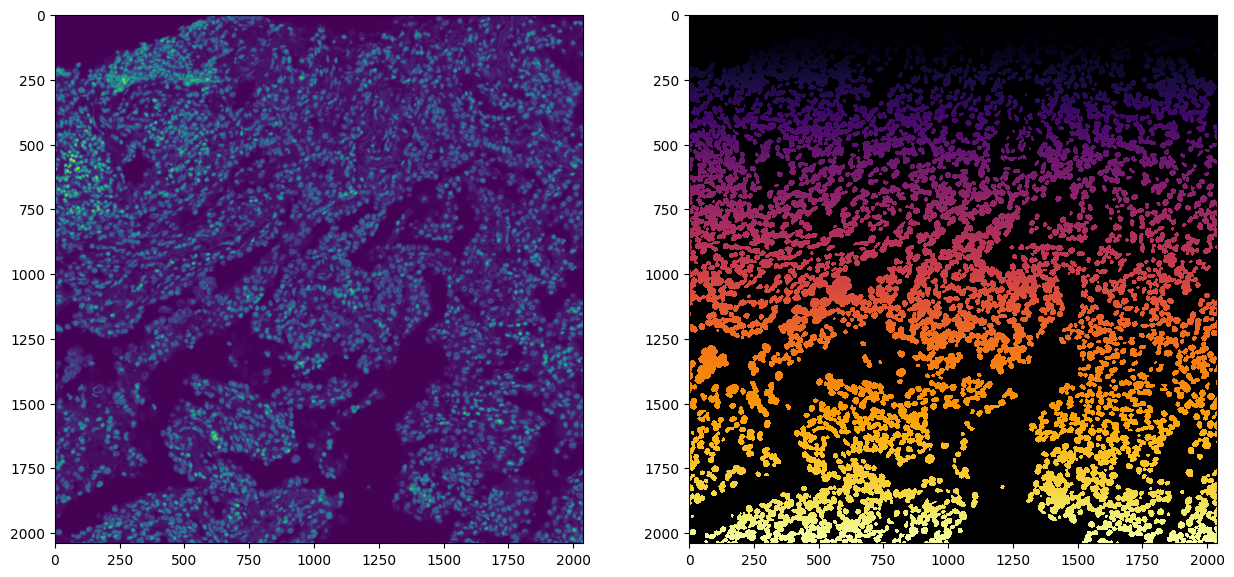

In [13]:
# visualize the results
fig,axes = plt.subplots(1,2,figsize=(15,10))

# display the original sample image
axes[0].imshow(im)

# display segmentation mask (each objects is displayed in different color)
axes[1].imshow(mask,cmap='inferno',interpolation='nearest')

#### Calculate properties of cells

Once a mask is defined, calculating signals of individual objects is a straightforward task.

In [ ]:
# read in and visualize different channels

im_cy3_path = im_path = './OMIBS2025/sample_images/2187T-5_2.0.4_P0007_Z00_Cy3.tif'
im_cy3 = imread(im_cy3_path)

im_cy5_path = im_path = './OMIBS2025/sample_images/2187T-5_2.0.4_P0007_Z00_Cy5.tif'
im_cy5 = imread(im_cy5_path)

im_fitc_path = im_path = './OMIBS2025/sample_images/2187T-5_2.0.4_P0007_Z00_FITC.tif'
im_fitc = imread(im_fitc_path)

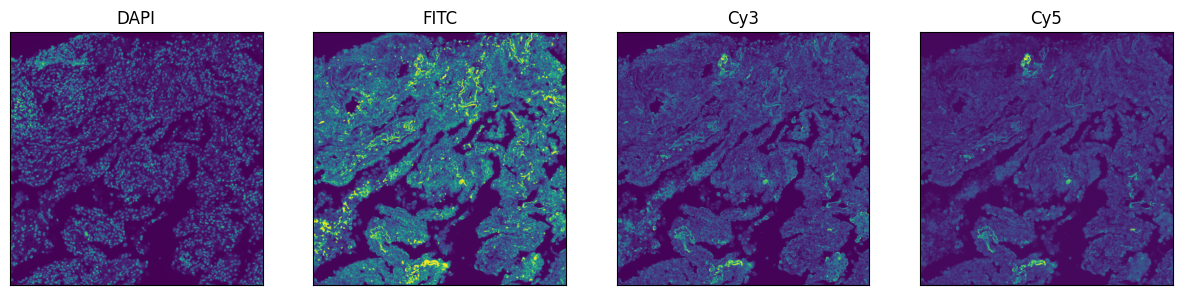

In [16]:
# visualize all the channels

fig,axes = plt.subplots(1,4,figsize=(15,10))

# display the original sample image
axes[0].imshow(im)
axes[0].set_title('DAPI')

axes[1].imshow(im_fitc,vmax=10000)
axes[1].set_title('FITC')

axes[2].imshow(im_cy3,vmax=10000)
axes[2].set_title('Cy3')

axes[3].imshow(im_cy5,vmax=4000)
axes[3].set_title('Cy5')

# remove ticks from the display
for ax in axes:

    ax.set_xticks([])
    ax.set_yticks([])

In [17]:
# define which properties of cells to calculate 
# see documentation here: https://scikit-image.org/docs/stable/api/skimage.measure.html#skimage.measure.regionprops

selected_properties = ['label','centroid','area','mean_intensity']

# put all the intensity channels together to create a nice package
all_channels = np.stack([im,im_fitc,im_cy3,im_cy5],axis=2)

# calculate properties of cells
my_data = regionprops_table(mask, intensity_image = all_channels, properties = selected_properties)

# put results in a nice table
my_data = pd.DataFrame(my_data)

In [ ]:
# display analysis results
my_data

,label,centroid-0,centroid-1,area,mean_intensity-0,mean_intensity-1,mean_intensity-2,mean_intensity-3
0,1,8.728358,608.414925,335.0,3210.280597,2439.104478,1495.656716,356.582090
1,2,12.785047,670.705607,428.0,4858.609813,3088.883178,2551.091121,662.098131
2,3,5.909408,704.153310,287.0,5448.777003,3366.031359,2285.825784,512.679443
3,4,2.984252,728.653543,127.0,4089.716535,3671.023622,2701.322835,602.850394
4,5,9.126280,745.187713,293.0,3136.737201,3392.952218,2869.484642,417.464164
...,...,...,...,...,...,...,...,...
4778,4779,2036.787234,155.010638,94.0,3978.712766,3048.425532,1623.765957,557.297872
4779,4780,2037.107143,317.250000,56.0,3719.303571,3111.053571,2052.214286,436.982143
4780,4781,2037.050847,1651.101695,59.0,2125.830508,3072.864407,1436.338983,504.898305
4781,4782,2037.174419,750.151163,86.0,3563.151163,3525.453488,1851.627907,480.279070
